In [ ]:
import cv2
import os
import numpy as np
from math import *
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import itertools
import functools

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from skimage.feature import hog
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from lesson_functions import *
np.random.seed(0xdeadbeef)

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [ ]:
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [ ]:
t=time.time()
cars = glob.iglob('data/vehicles/**/*.png')
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcars = glob.iglob('data/non-vehicles/**/*.png')
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

In [ ]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0xdeadbeef)

In [ ]:
clf = Pipeline([('scaling', StandardScaler()),
                 ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                ('classification', LinearSVC(loss='hinge')),
               ])

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

In [ ]:
print('Test Accuracy of classifier = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My classifier predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels')

In [ ]:
from shutil import copyfile

def make_hardneg(out_path, neg=True):
    y_pred = clf.predict(X)

    if neg:
        notcars = glob.glob('data/non-vehicles/**/*.png')
    else:
        cars = glob.glob('data/vehicles/**/*.png')
    offset = len(car_features)

    # Wrong indices
    wrong = np.nonzero(y_pred != y)[0]
    for w in wrong:
        # False positives
        if neg and y_pred[w] == 1 and y[w] == 0:
            fname = notcars[w - offset]
            copyfile(fname, out_path+'/hardneg_'+str(w - offset)+'.png')
        elif not neg and y_pred[w] == 0 and y[w] == 1:
            fname = cars[w]
            copyfile(fname, out_path+'/hardpos_'+str(w)+'.png')

# make_hardneg('data/hardpos/', False)
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X)
conf = confusion_matrix(y, y_pred)
print(conf)

In [ ]:
from sklearn.externals import joblib
config = dict(color_space=color_space, 
            spatial_size=spatial_size, hist_bins=hist_bins, 
            orient=orient, pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            hog_channel=hog_channel, spatial_feat=spatial_feat, 
            hist_feat=hist_feat, hog_feat=hog_feat)
joblib.dump({'model':clf, 'config':config}, 'models/clf_9727.pkl')

In [2]:
data = joblib.load('models/clf_9885_newhog.pkl')
# data = joblib.load('models/clf_9869.pkl')
# svc = data['model']
clf = data['model']
config = data['config']

color_space = config['color_space']
spatial_size = config['spatial_size']
hist_bins = config['hist_bins']
orient = config['orient']
pix_per_cell = config['pix_per_cell']
cell_per_block = config['cell_per_block']
hog_channel = config['hog_channel']
spatial_feat = config['spatial_feat']
hist_feat = config['hist_feat']
hog_feat = config['hog_feat']
print(config)

{'cell_per_block': 2, 'orient': 9, 'spatial_feat': True, 'color_space': 'YUV', 'spatial_size': (16, 16), 'hog_feat': True, 'hog_channel': 0, 'hist_bins': 16, 'hist_feat': True, 'pix_per_cell': 8}


In [3]:
def search_windows(img, windows, clf, color_space='RGB',
                    spatial_size=None, hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    if spatial_size is None:
        spatial_size = (32, 32)

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    all_features = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = np.array(features).reshape(1, -1)

        #6) Predict using your classifier
        dec = clf.decision_function(test_features)
        prediction = int(dec > 1)

        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [4]:
def create_windows(pyramid, image_size):
    output = []
    for w_size, y_lims in pyramid:
        windows = slide_window(image_size, x_start_stop=[None, None], y_start_stop=y_lims, 
                        xy_window=w_size, xy_overlap=(0.5, 0.5))
        output.append(windows)
#         output.extend(windows)
    return output

def multiscale_detect(image, clf, config, windows, verbose=False):
    
    color_space = config['color_space']
    spatial_size = config['spatial_size']
    hist_bins = config['hist_bins']
    orient = config['orient']
    pix_per_cell = config['pix_per_cell']
    cell_per_block = config['cell_per_block']
    hog_channel = config['hog_channel']
    spatial_feat = config['spatial_feat']
    hist_feat = config['hist_feat']
    hog_feat = config['hog_feat']
    
    candidates = search_windows(image, windows, clf, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    return candidates

def update_heatmap(candidates, image_shape, heatmap = None):
    if heatmap is None:
        heatmap = np.zeros((image_shape[0], image_shape[1]), np.uint8)

    for pt1, pt2 in candidates:
#     for x1, y1, x2, y2 in candidates:
        x1, y1 = pt1
        x2, y2 = pt2
        xv, yv = np.meshgrid(range(x1, x2), range(y1, y2))

        heatmap[yv, xv] += 1

#     cv2.GaussianBlur(heatmap, (31,31), 0, dst=heatmap)
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def find_vehicles(heatmap):
    # Detect clusters
    labels = label(heatmap)

    _, contours, _ = cv2.findContours(heatmap, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = [cv2.boundingRect(pts) for pts in contours]
    return bboxes

In [5]:
pyramid = [((64, 64),  [400, 500]),
           ((96, 96),  [400, 500]),
           ((128, 128),[450, 578]),
           ((192, 192),[450, None]),
#             ((256, 256),[450, None])
      ]
image_size = (720, 1280)
windows = create_windows(pyramid, image_size)

In [6]:
image = mpimg.imread('test_images/test3.jpg')

In [7]:
# Malisiewicz et al.
# http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
 
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
 
	# initialize the list of picked indexes	
	pick = []
 
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
 
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
 
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
 
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
 
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [40]:
from filters import kalman_predict, kalman_measure
from scipy.optimize import linear_sum_assignment
import functools
import collections

def bbox_overlap(box1, box2):
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2

#         area = (x2 - x1 + 1) * (y2 - y1 + 1)
    area = (x4 - x3 + 1) * (y4 - y3 + 1)

    xx1 = np.maximum(x1, x3)
    yy1 = np.maximum(y1, y3)
    xx2 = np.minimum(x2, x4)
    yy2 = np.minimum(y2, y4)

    # compute the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    # compute the ratio of overlap
    overlap = (w * h) / area
    return overlap

    
def centroid(box):
    x1, y1, x2, y2 = box
    return ((x1+x2)/2., (y1+y2)/2.)
    
class VehicleTracker(object):
    """
    Tracks vehicle candidates using a Kalman filter
    """
    def __init__(self, img_size, process_noise = 5.0, measurement_noise = 300.0):
        """
        Parameters
        ----------
        img_size : tuple
            The shape of the video frame
            
        process_noise : float
            Process noise for kalman filter [pixels^2]
        
        measurement_noise : float
            Measurement covariance in x and y directions [pixels^2]
        """
        self.img_size = img_size
        self.H = np.array([[1., 0., 0., 0., 0., 0.],
                           [0., 1., 0., 0., 0., 0.]])
        self.R = np.eye(2)*measurement_noise
        
        self.Q = np.eye(6)*process_noise
        self.F = np.array([[0., 0., 1., 0., 0., 0.],
                           [0., 0., 0., 1., 0., 0.],
                           [0., 0., 0., 0., 1., 0.],
                           [0., 0., 0., 0., 0., 1.],
                           [0., 0., 0., 0., 0., 0.],
                           [0., 0., 0., 0., 0., 0.]])
        
        self.P0 = np.eye(6)*4000.0  # Initial covariance of any new candidate
        self.predict = functools.partial(kalman_predict, F = self.F, Q = self.Q)
        self.measure = functools.partial(kalman_measure, H = self.H, R = self.R)
    
        self.candidates = []
    
    def create_candidate(self, meas):
        """
        Creates a new tracking candidate from a measurement (bounding box)
        
        Parameters
        ----------
        meas - tuple
            tuple of 4 numbers denoting the top-left and bottom-right corners of the box
        """
        # Position
        x = list(centroid(meas))
        # Velocity
        x.append(-0.01 if x[0] > self.img_size[1]/2 else 0.01)
        # Acceleration
        x.append(-0.01)
        x.extend([0.001, 0.001])
        
        return {'bbox': meas, 'x': np.array(x), 'P': np.copy(self.P0), 'age': 0}
        
    def detect(self, measurements):
        """
        Uses measurements from OpenCV detect vehicles in the video stream
        
        Parameters
        ----------
        measurements : list
            List of bounding boxes detected by the classifier (and heatmap)
        """
        obox_ul = np.array([(0.1*self.img_size[1], 0.1*self.img_size[0])])
        obox_br = np.array([(0.9*self.img_size[1], 0.9*self.img_size[0])])
        
        meas_centroid = [centroid(meas) for meas in measurements]
        if len(self.candidates) == 0:
            nonmax_meas = non_max_suppression_fast(np.array(measurements), overlapThresh=0.2)
            self.candidates = [self.create_candidate(meas) for meas in nonmax_meas]
        else:
            # Assign measurements to candidates based on overlap
            cand_measurements = collections.defaultdict(list)
            for j, (meas, cent) in enumerate(zip(measurements, meas_centroid)):
                # Overlap with each candidate
                overlap = [bbox_overlap(cand['bbox'], meas) for cand in self.candidates]
                # Distance to each candidate
                distance = [np.linalg.norm(cand['x'][:2] - cent) for cand in self.candidates]
                
                max_cand_idx = np.argmax(overlap)
                min_dist_idx = np.argmin(distance)
                
                if overlap[max_cand_idx] < 0.1 and distance[max_cand_idx] > 50:
                    self.candidates.append(self.create_candidate(meas))
                else:
                    # Assign measurement to candidate
                    if overlap[max_cand_idx] >= 0.1:
                        cand_measurements[max_cand_idx].append(meas)
                    else:
                        cand_measurements[min_dist_idx].append(meas)
            for i, cand in enumerate(self.candidates):
                meas_list = cand_measurements[i]
                x1, P1 = self.predict(cand['x'], cand['P'])
                for meas in meas_list:
                    x1, P1 = self.measure(z = centroid(meas), x = x1, P = P1)

                # Increment age if no measurements matched this candidate
                if not meas_list:
                    self.candidates[i]['age'] = cand['age'] + 1
                else:
                    self.candidates[i]['age'] = cand['age'] - 1
                    
                self.candidates[i]['x'] = x1
                self.candidates[i]['P'] = P1
                
                old_bbox = cand['bbox']
                bbox_list = np.array(meas_list + [cand['bbox']])
                w_list, h_list = bbox_list[:,2] - bbox_list[:,0], bbox_list[:,3] - bbox_list[:,1]
                w, h = np.max(w_list), np.max(h_list)
                
                new_bbox = (int(x1[0] - w/2), int(x1[1] - h/2), int(x1[0] + w/2), int(x1[1] + h/2))
                self.candidates[i]['bbox'] = new_bbox
            
            self.cleanup()

    def cleanup(self, max_age=20):
        """
        Deletes any candidates older than max_age
        
        Parameters
        ----------
        max_age : int
            Maximum age of candidate before which it is deleted
        """
        cand_1 = [c for c in self.candidates if c['age'] <= max_age]
        self.candidates = cand_1
    
    def draw_bboxes(self, image):
        for c in self.candidates:
            if c['age'] < -10:
                bbox = c['bbox']
                if np.trace(c['P']) < 10:
                    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,0,255), 3)
                else:
                    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 6)
        return image

tracker = VehicleTracker((720, 1280))
meas1 = [(864, 432, 928, 496), (816, 400, 912, 496), (1152, 400, 1248, 496)]
meas2 = [(874, 432, 918, 496), (826, 400, 912, 456), (1122, 400, 1238, 496)]
tracker.detect(meas1)
tracker.detect(meas2)
print(len(tracker.candidates))

2


In [41]:
import collections
def process_image(image, params):
    config, clf, all_windows = params['clf_config'], params['clf'], params['windows']

    if params['cache_enabled']:
        cache = process_image.cache
        if cache['heatmaps'] is None:
            cache['heatmaps'] = collections.deque(maxlen=params['heatmap_cache_length'])
        
        if 'tracker' not in cache:
            cache['tracker'] = VehicleTracker(image.shape)
        frame_ctr = cache['frame_ctr']
        tracker = cache['tracker']
        cache['frame_ctr'] += 1

        extra = [(c['bbox'][:2], c['bbox'][2:]) for c in tracker.candidates]
        windows = all_windows[frame_ctr % len(all_windows)] + extra
#         windows = itertools.chain(*all_windows)
    else:
        windows = itertools.chain(*all_windows)


    measurements = multiscale_detect(image, clf, config, windows)
    
#     current_heatmap = update_heatmap(measurements, image.shape)
    if params['cache_enabled']:
        pass
#         cache['heatmaps'].append(current_heatmap)
#         thresh_heatmap = sum(cache['heatmaps'])
    else:
        current_heatmap = update_heatmap(measurements, image.shape)
        thresh_heatmap = current_heatmap

    if params['cache_enabled']:
        Z = [tuple(itertools.chain(*b)) for b in measurements]
        tracker.detect(Z)
        im2 = tracker.draw_bboxes(np.copy(image))
    else:
        thresh_heatmap[thresh_heatmap < params['heatmap_threshold']] = 0
        cv2.GaussianBlur(thresh_heatmap, (31,31), 0, dst=thresh_heatmap)

        labels = label(thresh_heatmap)

        im2 = draw_labeled_bboxes(np.copy(image), labels)
    return im2

def clear_cache():
    process_image.cache = {
        'last_heatmap': None,
        'heatmaps': None,
        'frame_ctr': 0
    }

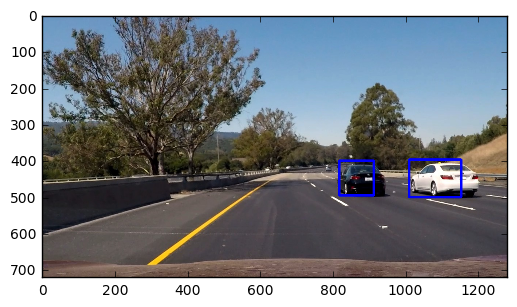

In [42]:
clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = False
params['heatmap_cache_length'] = 10
params['heatmap_threshold'] = 1

test_images = glob.glob('test_images/*.jpg')
for fname in test_images:
    im = mpimg.imread(fname)
    im2 = process_image(im, params)

#     pprint(len(process_image.cache['tracker'].candidates))

    plt.imshow(im2)

#     mpimg.imsave('output_images/'+os.path.basename(fname), im2)

In [44]:
clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = True
params['heatmap_cache_length'] = 25
params['heatmap_threshold'] = 5

vid_output = 'test_video_out.mp4'
clip = VideoFileClip('test_video.mp4')

In [43]:
clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = True
params['heatmap_cache_length'] = 25
params['heatmap_threshold'] = 5

vid_output = 'project_short_out.mp4'
clip = VideoFileClip('project_short.mp4')

In [33]:
vid_clip = clip.fl_image(lambda x: process_image(x, params))
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_short_out.mp4
[MoviePy] Writing video project_short_out.mp4


100%|█████████▉| 200/201 [00:16<00:00,  8.84it/s]     | 3/201 [00:00<00:07, 25.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_short_out.mp4 

CPU times: user 13 s, sys: 819 ms, total: 13.8 s
Wall time: 19.7 s


In [34]:
from pprint import pprint
pprint(len(process_image.cache['tracker'].candidates))

2


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

In [36]:
params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = True
params['heatmap_cache_length'] = 25
params['heatmap_threshold'] = 5

vid_output = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')

In [37]:
vid_clip = clip.fl_image(lambda x: process_image(x, params))
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [03:05<00:00,  6.45it/s]    | 3/1261 [00:00<01:27, 14.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 2min 2s, sys: 8.14 s, total: 2min 10s
Wall time: 3min 9s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

In [39]:
from pprint import pprint
pprint(len(process_image.cache['tracker'].candidates))

2
